In [1]:
import time
import string
import re
import nltk
import ujson as json
import pandas as pd
import collections
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import warnings
import ast
%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
trump_df = pd.read_csv('tweets_01-08-2021.csv')
trump_df['date'] = pd.to_datetime(trump_df['date'])
trump_df['isFlagged'] = trump_df['isFlagged'].apply(lambda x : 1 if x == 't' else 0)
trump_df['isRetweet'] = trump_df['isRetweet'].apply(lambda x : 1 if x == 't' else 0)
trump_df['isDeleted'] = trump_df['isDeleted'].apply(lambda x : 1 if x == 't' else 0)
trump_df = trump_df.drop(columns=['device'])

In [3]:
print(trump_df.shape)
print(trump_df.date.min())
print(trump_df.date.max())

(56571, 8)
2009-05-04 18:54:25
2021-01-08 15:44:28


In [4]:
trump_df.head(2)

,id,text,isRetweet,isDeleted,favorites,retweets,date,isFlagged
0,98454970654916608,Republicans and Democrats have both created ou...,0,0,49,255,2011-08-02 18:07:48,0
1,1234653427789070336,I was thrilled to be back in the Great city of...,0,0,73748,17404,2020-03-03 01:34:50,0


In [5]:
parler_df = pd.read_csv('parler_data000000000133.csv')

In [6]:
parler_df.head(2)

,Unnamed: 0,comments,body,bodywithurls,createdAtformatted,creator,datatype,followers,following,hashtags,id,parent,posts,sensitive,upvotes,username,verified,impressions,reposts
0,1,-1,OH JOE.\nJoe Biden says police officers should...,OH JOE.\nJoe Biden says police officers should...,2020-10-16 01:30:13 UTC,ea5548d2b27a47d5a118a954ac4a41af,posts,87000.0,15000.0,['joebiden'],9202e086e2814124a8dc17688f50b2c9,NaN,5600.0,0.0,182.0,EllieBOfficial,1.0,15000.0,163.0
1,2,-1,"THANK YOU! In an executive order, President Tr...","THANK YOU! In an executive order, President Tr...",2020-12-29 03:15:22 UTC,e412b8e19c2f43e1a249c7df0e7690a3,posts,5000.0,6600.0,[],b18a01c2f0d9453ca009876f0a215c2a,NaN,2800.0,0.0,101.0,TexanBell,0.0,4200.0,57.0


In [7]:
parler_df = parler_df[parler_df.createdAtformatted > '2020-01-01']
parler_df['createdAtformatted'] = pd.to_datetime(parler_df['createdAtformatted'])
parler_df['date'] = parler_df['createdAtformatted']
parler_df['date'] =  parler_df['date'].dt.date
parler_df = parler_df.dropna(subset=['body', 'bodywithurls'])

In [8]:
parler_df.head(2)

,Unnamed: 0,comments,body,bodywithurls,createdAtformatted,creator,datatype,followers,following,hashtags,id,parent,posts,sensitive,upvotes,username,verified,impressions,reposts,date
0,1,-1,OH JOE.\nJoe Biden says police officers should...,OH JOE.\nJoe Biden says police officers should...,2020-10-16 01:30:13+00:00,ea5548d2b27a47d5a118a954ac4a41af,posts,87000.0,15000.0,['joebiden'],9202e086e2814124a8dc17688f50b2c9,NaN,5600.0,0.0,182.0,EllieBOfficial,1.0,15000.0,163.0,2020-10-16
1,2,-1,"THANK YOU! In an executive order, President Tr...","THANK YOU! In an executive order, President Tr...",2020-12-29 03:15:22+00:00,e412b8e19c2f43e1a249c7df0e7690a3,posts,5000.0,6600.0,[],b18a01c2f0d9453ca009876f0a215c2a,NaN,2800.0,0.0,101.0,TexanBell,0.0,4200.0,57.0,2020-12-29


# Similarities between Twitter and Parler hashtags

In [9]:
trump_df['hashtags'] = trump_df.text.str.findall(r'\#(\w+)')
twitter_hashtags_df = trump_df[trump_df.text.str.contains('#')].copy()

parler_hashtags_df = parler_df[parler_df.body.str.contains('#')].copy()
parler_hashtags_df['hashtags'] = parler_hashtags_df.hashtags.str.lower().apply(lambda s: list(ast.literal_eval(s)))


tweets = twitter_hashtags_df.copy()
parlers =  parler_hashtags_df.copy()

In [10]:
def extract_popular_hashtags(df, n):
    acc = []
    for l in df.hashtags:
        acc = acc + l
    mcs = collections.Counter(acc).most_common(n)
    dic = {}
    for el in mcs:
        dic[el[0]] = el[1]
    return dic

In [11]:
def extract_popular_hashtag_from_date(trump_df,parler_df, date_from, date_to,n):
    trump_week_df = trump_df[trump_df.date.between(date_from, date_to)]
    parler_week_df = parler_df[parler_df.date.between(date_from, date_to)]
    return extract_popular_hashtags(trump_week_df,n), extract_popular_hashtags(parler_week_df,n)

In [12]:
def create_word_cloud_from_freq(freq):
    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate_from_frequencies(freq)
    return wordcloud


In [13]:
def plot_words(twitter_freq, parler_freq, date_from,date_to):
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,15))
#     fig.suptitle('Week: {} - {}'.format(date_from,date_to), fontsize=16)
    wordcloud = create_word_cloud_from_freq(twitter_freq)
    ax1.imshow(wordcloud)
    ax1.set_title("Twitter")
    wordcloud = create_word_cloud_from_freq(parler_freq)
    ax2.imshow(wordcloud)
    ax2.set_title("Parler")
    ax1.axis('off')
    ax2.axis('off')

In [14]:
def display_popular_hashtags_per_period(trump_df,parler_df, date_from, date_to,n):
    freqs = extract_popular_hashtag_from_date(trump_df,parler_df,date_from,date_to,n)
    plot_words(freqs[0], freqs[1],date_from,date_to)

In [15]:
tweets['date'] = pd.to_datetime(tweets['date'])
parlers['date'] = pd.to_datetime(parlers['date'])

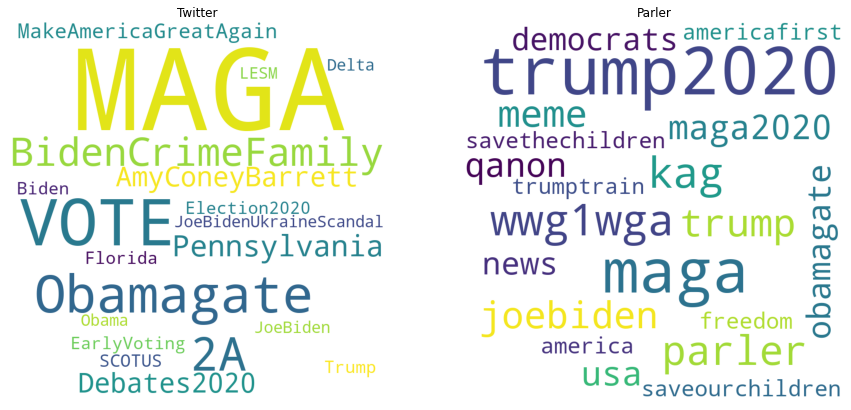

In [16]:
display_popular_hashtags_per_period(tweets,parlers, '2020-10-01', '2020-10-31',20)

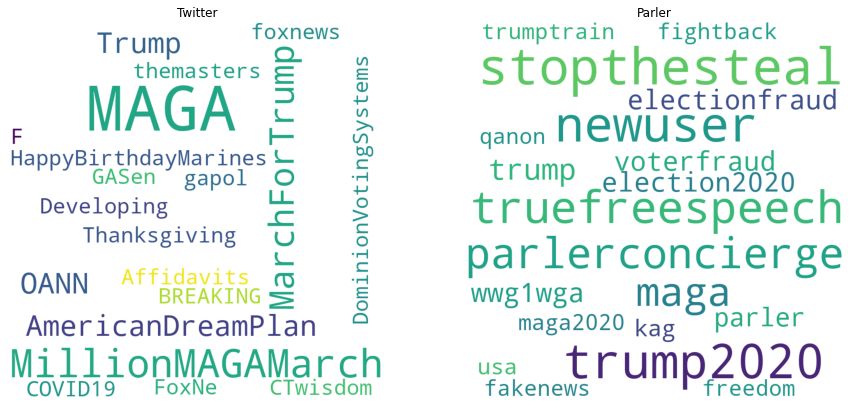

In [17]:
display_popular_hashtags_per_period(tweets,parlers, '2020-11-01', '2020-11-30',20)

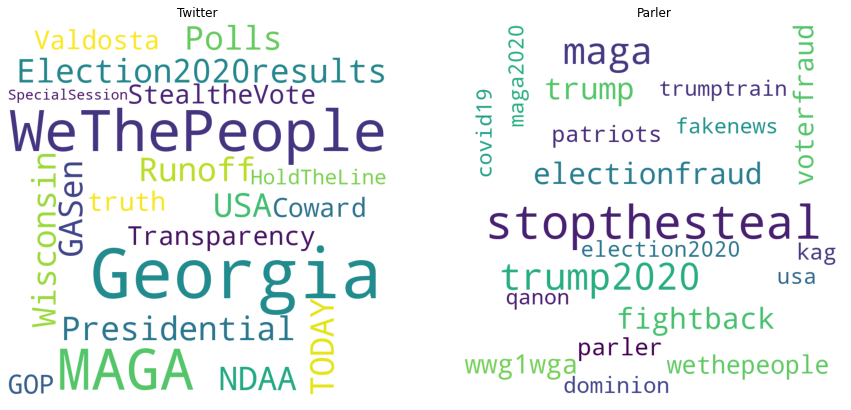

In [18]:
display_popular_hashtags_per_period(tweets,parlers, '2020-12-01', '2020-12-31',20)

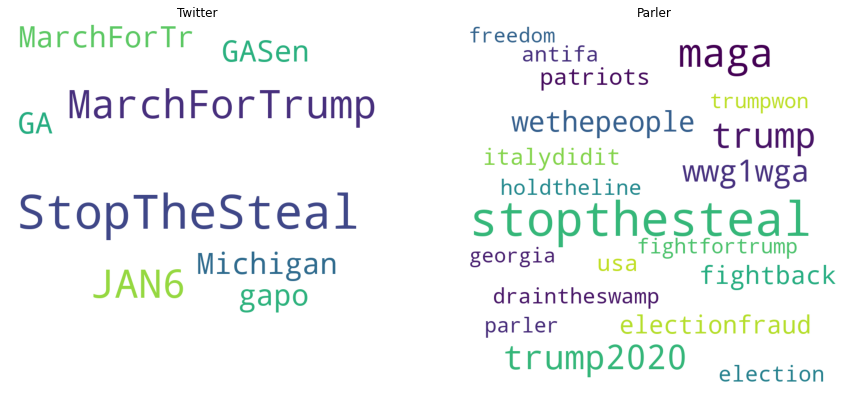

In [19]:
display_popular_hashtags_per_period(tweets,parlers, '2021-01-01', '2021-01-08',20)

# Term Similarities per week

In [20]:
def extract_popular_terms(message_body, n):
    acc = []
    for txt in message_body:
        txt = txt.lower()
        txt = re.sub(r'http\S+', '', txt)
        txt = re.sub('\w*\d\w*','', txt)
        txt = re.sub(r"\b[a-zA-Z]\b", "", txt)
        word_tokens = re.findall(r'\w{5,}',txt)
        
        filtered_sentence = [w for w in word_tokens if not w in (list(STOPWORDS) + list(string.punctuation)+['’',"”"])] 
        acc = acc + filtered_sentence
    mcs = collections.Counter(acc).most_common(n)
    dic = {}
    for el in mcs:
        dic[el[0]] = el[1]
    return dic

In [21]:
def extract_popular_keyword_from_date(trump_df,parler_df, date_from, date_to,n):
    trump_week_df = trump_df[trump_df.date.between(date_from, date_to)]
    parler_week_df = parler_df[parler_df.date.between(date_from, date_to)]
    return extract_popular_terms(trump_week_df.text,n), extract_popular_terms(parler_week_df.body,n)

In [22]:
def display_popular_word_for_week(trump_df,parler_df, date_from, date_to,n):
    week_freqs = extract_popular_keyword_from_date(trump_df,parler_df,date_from,date_to,n)
    plot_words(week_freqs[0], week_freqs[1],date_from,date_to)

In [23]:
trump_df['date'] = pd.to_datetime(trump_df['date'])
parler_df['date'] = pd.to_datetime(parler_df['date'])

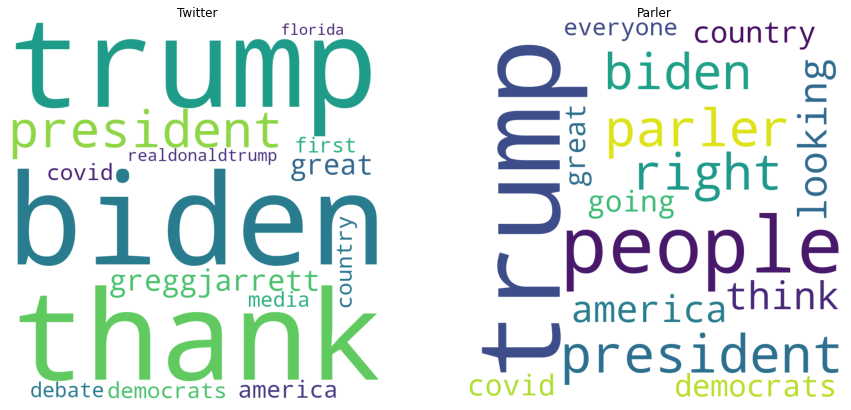

In [24]:
display_popular_word_for_week(trump_df,parler_df,'2020-10-01','2020-10-07',15)

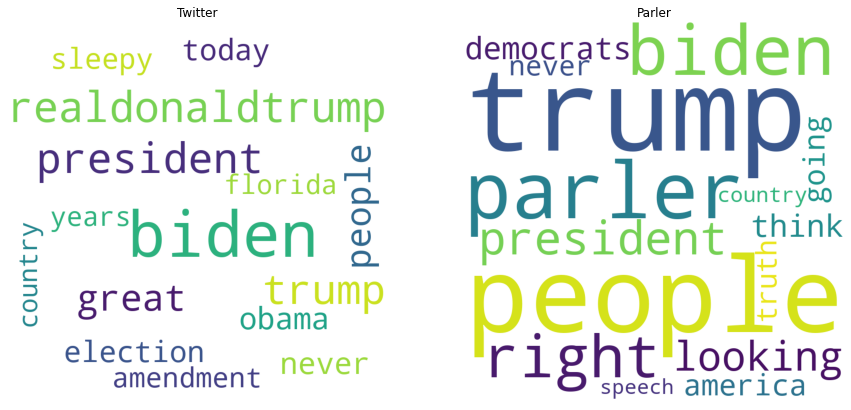

In [25]:
display_popular_word_for_week(trump_df,parler_df,'2020-10-07','2020-10-14',15)

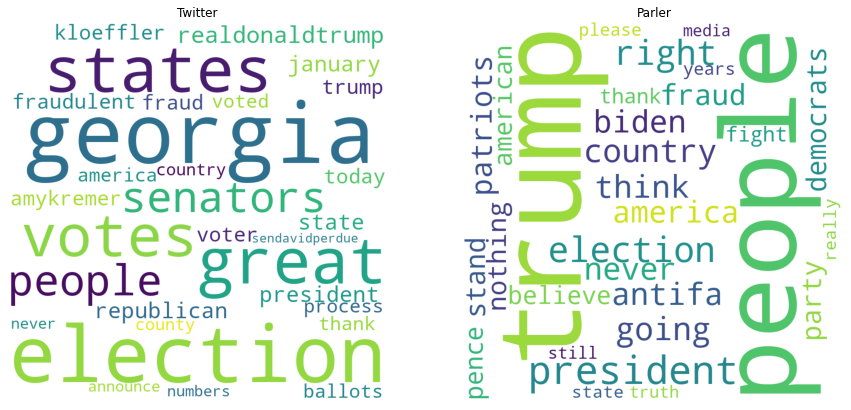

In [26]:
display_popular_word_for_week(trump_df,parler_df,'2021-01-01','2021-01-07',30)

# N-Gram  similarities between Twitter and Parler

Analyzing the most freqent bigrams in Trump's tweets and see the freqency of appearance in Parler

In [27]:
trump_twitter_ngram_df = trump_df.copy()
parler_df_ngram_df = parler_df.copy()
trump_twitter_ngram_df['text'] = trump_twitter_ngram_df['text'].astype(str)
parler_df_ngram_df['body'] = parler_df_ngram_df['body'].astype(str)

In [28]:
filt = trump_twitter_ngram_df['text'].str.contains(r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})', regex=True)
trump_twitter_ngram_df = trump_twitter_ngram_df[~filt]

filt = parler_df_ngram_df['body'].str.contains(r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})', regex=True)
parler_ngram_df = parler_df_ngram_df[~filt]

/Users/jean/opt/anaconda3/lib/python3.7/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [29]:
parler_ngram_df.rename(columns = {'body':'text'}, inplace = True)

/Users/jean/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [30]:
stoplist = stopwords.words('english') + ['though']

def extract_pop_bigram(text_df):
    c_vec = CountVectorizer(stop_words=stoplist + ['rt'], ngram_range=(2,3))
    # matrix of ngrams
    ngrams = c_vec.fit_transform(text_df)
    # count frequency of ngrams
    count_values = ngrams.toarray().sum(axis=0)
    # list of ngrams
    vocab = c_vec.vocabulary_

    df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})
    return df_ngram

In [31]:
def select_text_for_period(df, date_from, date_to):
    df = df[df.date.between(date_from, date_to)]
    return extract_pop_bigram(df['text'])
    
        

In [32]:
select_text_for_period(trump_twitter_ngram_df, '2020-10-01', '2021-01-08')[:20]

,frequency,bigram/trigram
0,95,joe biden
1,56,fake news
2,51,president realdonaldtrump
3,42,supreme court
4,39,president trump
5,36,sleepy joe
6,35,voter fraud
7,30,united states
8,25,radical left
9,23,section 230


In [33]:
def first_occurence(term_expr):
    print('Twitter first occurence: {}'.format(trump_df[trump_df.text.str.lower().str.contains(term_expr, regex=True)].date.min()))
    print('Parler first occurence: {}'.format(parler_df[parler_df.body.str.lower().str.contains(term_expr, regex=True)].createdAtformatted.min()))

In [34]:
def aggregate_parler_occurence(term_expr):
    return parler_df[parler_df.body.str.lower().str.contains(term_expr, regex=True)].groupby([pd.Grouper(key = 'date', freq = '7D')])['body'].size().to_frame().reset_index()

In [35]:
def term_occurence_of(term_expr):
    first_occurence(term_expr)
    df = aggregate_parler_occurence(term_expr)
    df.plot(figsize=(15,5), x='date', legend=False)
    plt.xlabel("Date",size=16)
    plt.ylabel("Occurence ({})".format(term_expr),size=16)

Twitter first occurence: 2019-04-17 01:24:39
Parler first occurence: 2020-03-04 12:33:59+00:00


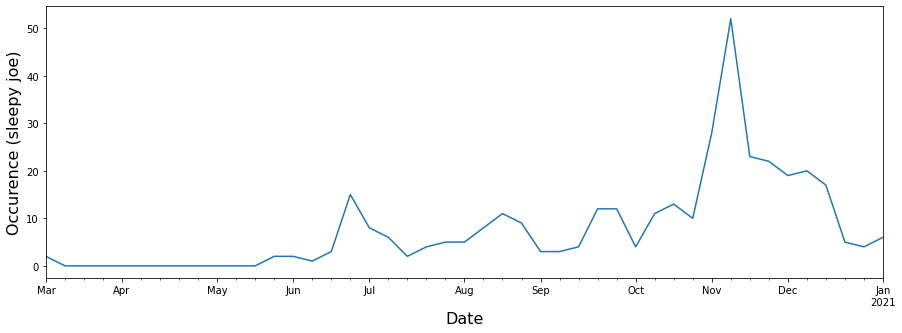

In [36]:
term_occurence_of("sleepy joe")

Twitter first occurence: 2020-11-21 20:34:36
Parler first occurence: 2020-06-08 04:52:41+00:00


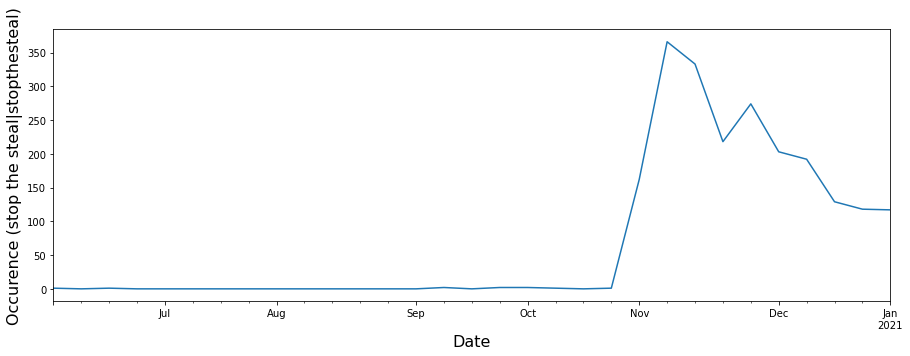

In [37]:
term_occurence_of("stop the steal|stopthesteal")

Twitter first occurence: 2012-06-07 16:29:01
Parler first occurence: 2020-01-04 23:57:25+00:00


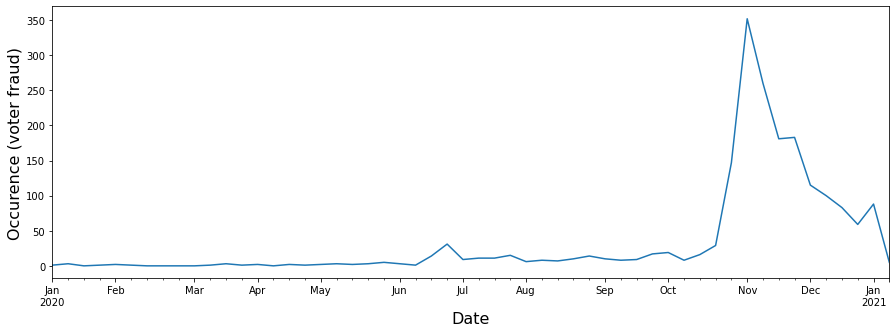

In [38]:
term_occurence_of("voter fraud")

Twitter first occurence: 2018-06-30 11:22:41
Parler first occurence: 2020-01-17 01:08:17+00:00


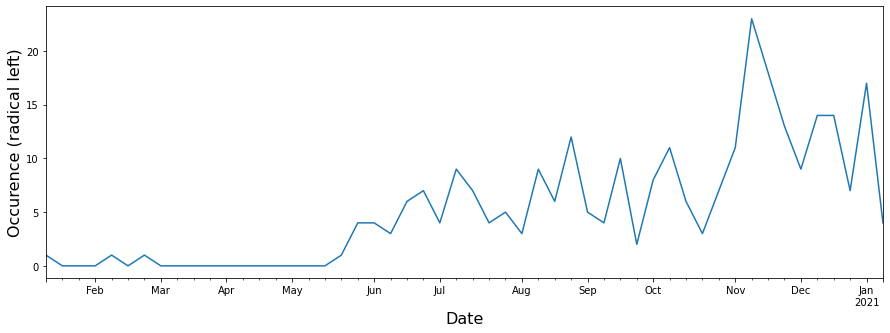

In [39]:
term_occurence_of("radical left")

Twitter first occurence: 2016-12-10 14:11:49
Parler first occurence: 2020-01-01 22:28:59+00:00


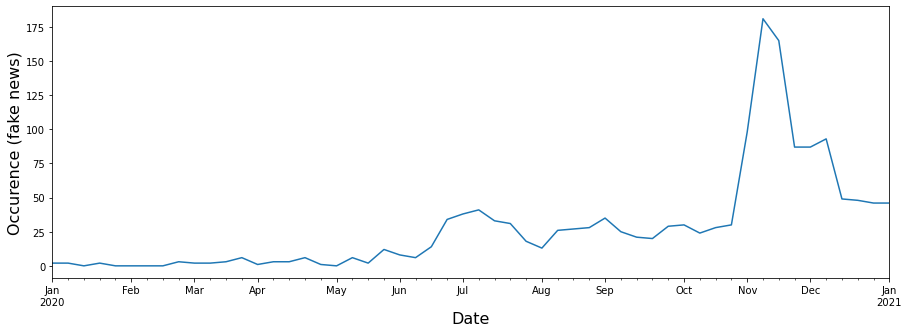

In [40]:
term_occurence_of("fake news")

Twitter first occurence: 2020-12-03 15:31:39
Parler first occurence: 2020-08-18 13:23:56+00:00


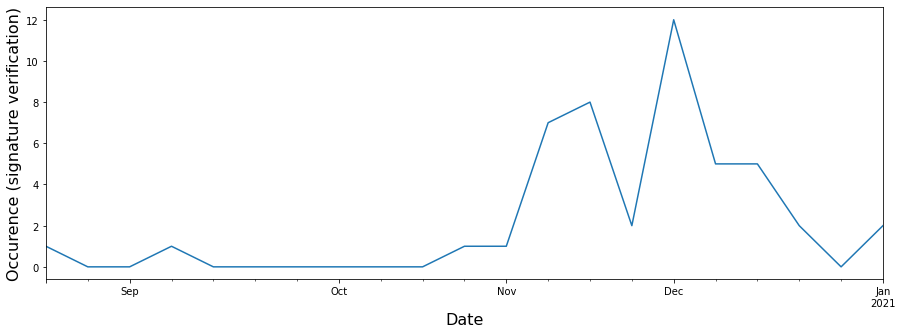

In [41]:
term_occurence_of("signature verification")

# Parler reactions to Trump's tweets


In [42]:
trump_df[trump_df.text.str.lower().str.contains("stopthesteal", regex=True)]

,id,text,isRetweet,isDeleted,favorites,retweets,date,isFlagged,hashtags
102,1346469204740902915,Pleased to announce that @KLoeffler &amp; @sen...,0,0,177332,42347,2021-01-05 14:50:49,0,[StopTheSteal]
2439,1342815318918443010,"RT @ali: Our friend, Congressman @andybiggs4az...",1,0,0,3521,2020-12-26 12:51:34,0,"[StopTheSteal, DoNotCertify, JAN6]"
2659,1345088187811700748,"The BIG Protest Rally in Washington, D.C., wil...",0,0,66377,19369,2021-01-01 19:23:09,0,[]
2660,1345095714687377418,"The BIG Protest Rally in Washington, D.C., wil...",0,0,293323,70592,2021-01-01 19:53:03,0,[]
2697,1345503150745247746,"...And after they see the facts, plenty more t...",0,0,147990,35976,2021-01-02 22:52:04,0,[StopTheSteal]
2719,1345736811906273282,"“Georgia election data, just revealed, shows t...",0,0,157331,43633,2021-01-03 14:20:33,0,[StopTheSteal]


In [43]:
stop_df = parler_df[parler_df.createdAtformatted.between('2021-01-01', '2021-01-03')]

In [44]:
def aggregate_parler_occurence_f(term_expr,fr):
    return stop_df[stop_df.body.str.lower().str.contains(term_expr, regex=True)].groupby([pd.Grouper(key = 'createdAtformatted', freq = fr)])['body'].size().to_frame().reset_index()

Text(0, 0.5, 'Occurence')

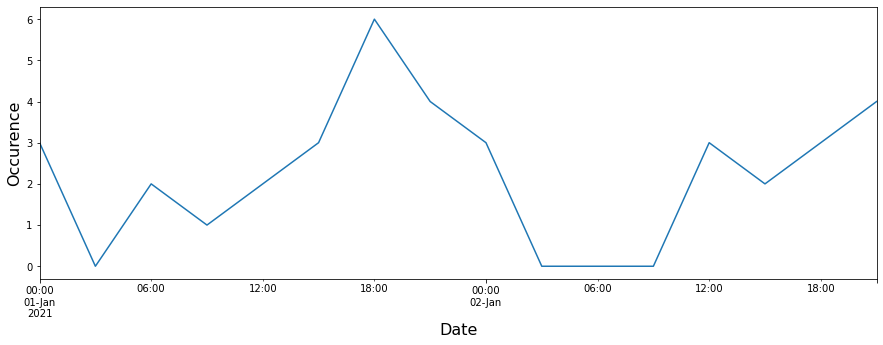

In [45]:
df = aggregate_parler_occurence_f('stopthesteal|stop the steal','3H')
df.plot(figsize=(15,5), x='createdAtformatted', legend=False)
plt.xlabel("Date",size=16)
plt.ylabel("Occurence",size=16)

We observe an increase in the activity related to the expression **"stop the steal"** around the same time Donald Trump tweeted using the hashtag #StopTheSteal. For performance issues, the exploration has been done on a small sample of the parler dataset. With more data the relationship should be more epxlicit 